---
# Install the required packages

If needed install the following packages:

In [32]:
# !pip install tensorflow keras

---
# Imports

In [33]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM

import matplotlib.pyplot as plt
import seaborn as sns

---
# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of **R peak interval** for a patient. Your task involves employing deep learning methods to forecast the **required measurements**. To accomplish this you will be using a patient's ECG measurements from the MITDB database, which consists of the following values:

- R peak Interval (int: the time the R peak appeared)
- Beat Annotation (string: the beat type)
- Episode Annotation (string: the episode type)

**Note: You are required to perform this laboratory assignment on your local machine.**


# Read the data

You are required to load the given data from the `201_cleaned.ann` file (csv format). Load the data into a `pandas dataframe` and display the first 5 rows of the dataframe.

In [34]:
df = pd.read_csv('201_cleaned.ann')

In [35]:
df.head(5)

,R peak Interval,Beat Annotation,Episode Annotation
0,55,N,(AFIB
1,144,N,(AFIB
2,238,N,(AFIB
3,314,N,(AFIB
4,412,N,(AFIB


---
# EDA

## Explore the Beat Annotation Distribution

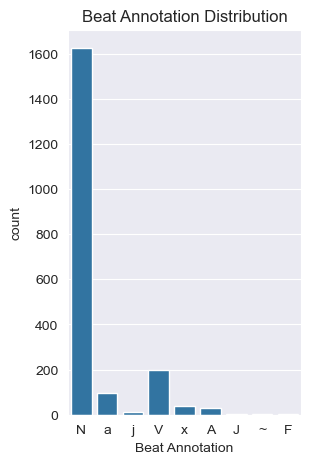

In [36]:
fig = plt.figure(figsize=(3,5))

sns.countplot(x='Beat Annotation', data=df)

plt.title('Beat Annotation Distribution')
plt.show()

## Explore the Episode Annotation Distribution

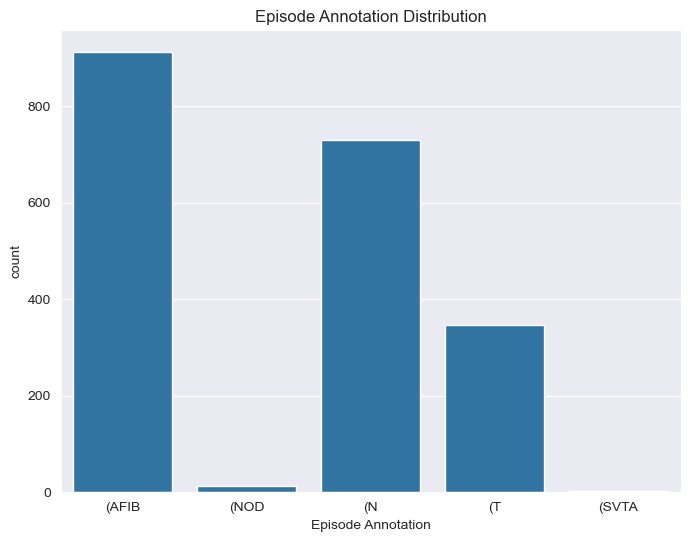

In [37]:
fig = plt.figure(figsize=(8,6))

sns.countplot(x='Episode Annotation', data=df)

plt.title('Episode Annotation Distribution')
plt.show()

---
# Feature Engineering

## Re-Labeling the data (Beat Annotation)

Re-label the data into 3 beat types:
- Normal Beat (N)
- Ventricular Beat (V)
- Other Beats (Other)

In [38]:
df['Beat Annotation'] = df['Beat Annotation'].map(lambda x: x if x in ['N', 'V'] else 'Other')

Check that the mapping worked:

In [39]:
df['Beat Annotation'].value_counts()

Beat Annotation
N        1625
V         198
Other     181
Name: count, dtype: int64

## Re-Labeling the data (Episode Annotation)

Re-label the data into 3 beat types:
- Normal Episode: (N
- Atrial Fibrillation: (AFIB
- Other Episode: (Other

In [40]:
df['Episode Annotation'] = df['Episode Annotation'].map(lambda x: x if x in ['(N', '(AFIB'] else '(Other')

Check that the mapping worked:

In [41]:
df['Episode Annotation'].value_counts()

Episode Annotation
(AFIB     911
(N        730
(Other    363
Name: count, dtype: int64

## Create Lag Features (5 prev values) for R peak Interval measurement

Apply a lag for the R peak Interval, creating a set of features representing the historical patient data. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [42]:
for i in range(1, 6):
    df['R peak Interval -' + str(i)] = df['R peak Interval'].shift(i)

In [43]:
df.dropna(inplace=True)

Check that the mapping worked:

In [44]:
df.head(10)

,R peak Interval,Beat Annotation,Episode Annotation,R peak Interval -1,R peak Interval -2,R peak Interval -3,R peak Interval -4,R peak Interval -5
5,493,N,(AFIB,412.0,314.0,238.0,144.0,55.0
6,562,N,(AFIB,493.0,412.0,314.0,238.0,144.0
7,682,N,(AFIB,562.0,493.0,412.0,314.0,238.0
8,776,N,(AFIB,682.0,562.0,493.0,412.0,314.0
9,866,N,(AFIB,776.0,682.0,562.0,493.0,412.0
10,944,N,(AFIB,866.0,776.0,682.0,562.0,493.0
11,1026,N,(AFIB,944.0,866.0,776.0,682.0,562.0
12,1110,N,(AFIB,1026.0,944.0,866.0,776.0,682.0
13,1204,N,(AFIB,1110.0,1026.0,944.0,866.0,776.0
14,1318,N,(AFIB,1204.0,1110.0,1026.0,944.0,866.0


## Generate R-R interval features


For the past 5 R peak intervals ($R_{i}, i \in \{-1, -2, -3, -4, -5\}$), generate the 4 R-R intervals as features.

$RR_{i} = R_{i} - R_{i-1}$

In [45]:
for i in range(1, 5):
    df[f'RR {i}'] = df[f'R peak Interval -{i}'] - df[f'R peak Interval -{i+1}']

Additionally, generate the current R-R Interval, which we will be using as a target.  

$RR_{curr} = (R_{0} - R_{-1})$

In [46]:
df['RR'] = df['R peak Interval'] - df['R peak Interval -1']

Check that the mapping worked:

In [47]:
df.head(10)

,R peak Interval,Beat Annotation,Episode Annotation,R peak Interval -1,R peak Interval -2,R peak Interval -3,R peak Interval -4,R peak Interval -5,RR 1,RR 2,RR 3,RR 4,RR
5,493,N,(AFIB,412.0,314.0,238.0,144.0,55.0,98.0,76.0,94.0,89.0,81.0
6,562,N,(AFIB,493.0,412.0,314.0,238.0,144.0,81.0,98.0,76.0,94.0,69.0
7,682,N,(AFIB,562.0,493.0,412.0,314.0,238.0,69.0,81.0,98.0,76.0,120.0
8,776,N,(AFIB,682.0,562.0,493.0,412.0,314.0,120.0,69.0,81.0,98.0,94.0
9,866,N,(AFIB,776.0,682.0,562.0,493.0,412.0,94.0,120.0,69.0,81.0,90.0
10,944,N,(AFIB,866.0,776.0,682.0,562.0,493.0,90.0,94.0,120.0,69.0,78.0
11,1026,N,(AFIB,944.0,866.0,776.0,682.0,562.0,78.0,90.0,94.0,120.0,82.0
12,1110,N,(AFIB,1026.0,944.0,866.0,776.0,682.0,82.0,78.0,90.0,94.0,84.0
13,1204,N,(AFIB,1110.0,1026.0,944.0,866.0,776.0,84.0,82.0,78.0,90.0,94.0
14,1318,N,(AFIB,1204.0,1110.0,1026.0,944.0,866.0,94.0,84.0,82.0,78.0,114.0


## Encode the categorical variables

In [48]:
beat_enc = OrdinalEncoder()
episode_enc = OrdinalEncoder()

df['Beat Annotation'] = beat_enc.fit_transform(df[['Beat Annotation']])
df['Episode Annotation'] = episode_enc.fit_transform(df[['Episode Annotation']])

Check that the mapping worked:

In [49]:
df.head(10)

,R peak Interval,Beat Annotation,Episode Annotation,R peak Interval -1,R peak Interval -2,R peak Interval -3,R peak Interval -4,R peak Interval -5,RR 1,RR 2,RR 3,RR 4,RR
5,493,0.0,0.0,412.0,314.0,238.0,144.0,55.0,98.0,76.0,94.0,89.0,81.0
6,562,0.0,0.0,493.0,412.0,314.0,238.0,144.0,81.0,98.0,76.0,94.0,69.0
7,682,0.0,0.0,562.0,493.0,412.0,314.0,238.0,69.0,81.0,98.0,76.0,120.0
8,776,0.0,0.0,682.0,562.0,493.0,412.0,314.0,120.0,69.0,81.0,98.0,94.0
9,866,0.0,0.0,776.0,682.0,562.0,493.0,412.0,94.0,120.0,69.0,81.0,90.0
10,944,0.0,0.0,866.0,776.0,682.0,562.0,493.0,90.0,94.0,120.0,69.0,78.0
11,1026,0.0,0.0,944.0,866.0,776.0,682.0,562.0,78.0,90.0,94.0,120.0,82.0
12,1110,0.0,0.0,1026.0,944.0,866.0,776.0,682.0,82.0,78.0,90.0,94.0,84.0
13,1204,0.0,0.0,1110.0,1026.0,944.0,866.0,776.0,84.0,82.0,78.0,90.0,94.0
14,1318,0.0,0.0,1204.0,1110.0,1026.0,944.0,866.0,94.0,84.0,82.0,78.0,114.0


---
# Model Training

## Remove unnecessary columns

For the purposes of training we will only be using the following columns as features:
- Beat Annotation
- Episode Annotation
- **All historical** 4 RR intervals

Moreover, the target column we will be forcasting is the ```current RR``` interval.

In [50]:
FEATURE_COLUMNS = ['RR 1', 'RR 2', 'RR 3', 'RR 4', 'Beat Annotation', 'Episode Annotation']
TARGET_COLUMN = 'RR'

In [51]:
X = df[FEATURE_COLUMNS]
y = df[TARGET_COLUMN]

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Neural Network (RNN / CRNN)

Create a deep (convolutional) recurrent neural network using:
- Minimum of 1 Convolutional Layer **(+2 points Optional)** and
- Minimum of 1 LSTM Layer

In [53]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

/Users/gorazdfilipovski/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
model_2 = Sequential()

model_2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_2.add(LSTM(50, activation='relu'))

model_2.add(Dense(1))

/Users/gorazdfilipovski/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Reshape Data If Necessary**

In [55]:
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

Compile and fit the model (Run only train 3 Epoch).

In [56]:
# Compile the model
model.compile(optimizer='adam', loss='mse')
model_2.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X_train, y_train, epochs=3)
model_2.fit(X_train, y_train, epochs=3)

Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 12477.5469
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1287.4484
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1369.4050
Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 10607.1084
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1376.9897
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1167.2560


In [57]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 5, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 2, 50)          │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,331 (509.11 KB)

 Trainable params: 43,443 (169.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 86,888 (339.41 KB)

In [58]:
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 6, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

---
# Model Evaluation

Use the trained model to make predictions for the test set.

In [59]:
y_pred = model.predict(X_test)
y_pred2 = model_2.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [60]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

Root Mean Squared Error: 45.383265074671826
Mean Absolute Error: 28.988286533355712
R2 Score: 0.006751144655792518


In [61]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred2)))
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred2))
print('R2 Score:', r2_score(y_test, y_pred2))

Root Mean Squared Error: 42.77277491595107
Mean Absolute Error: 27.938786144256593
R2 Score: 0.11773012525278037
